In [5]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.pylab import normal
import seaborn as sns
import os

import joblib

import librosa as lb
# import librosa.display as ld
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, models
# from tensorflow.keras.utils import to_categorical

# import sounddevice as sd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [6]:
# to be changed to new dataset folder with three classes: emergency, non-emergency, alarming
EMERGENCY_PATH = os.path.join("..", "datasets", "emergency")
ALARMING_PATH = os.path.join("..", "datasets", "alarming")
NORMAL_PATH = os.path.join("..", "datasets", "non-emergency")


def load_audio_files(directory, filename):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} does not exist.")

    if filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        try:
            wav, sr = lb.load(file_path, sr=16000, mono=True)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return wav, sr


In [7]:
def extract_features(audio, sample_rate):
    hop_length = 200
    win_length = 400
    max_len = 160
    n_fft = 512

    def float32(y):
        arr = np.asarray(y)
        if arr.dtype == np.int16:
            return arr.astype(np.float32) / 32768.0
        if arr.dtype == np.int32:
            return arr.astype(np.float32) / 2147483648.0
        return arr.astype(np.float32, copy=False)

    y = float32(audio).squeeze()

    mfcc = lb.feature.mfcc(y=y, sr=sample_rate, n_mfcc=20, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
    mfcc_delta = lb.feature.delta(mfcc)
    mfcc_delta2 = lb.feature.delta(mfcc, order=2)

    rms = lb.feature.rms(y=y, frame_length=win_length, hop_length=hop_length)
    zcr = lb.feature.zero_crossing_rate(y=y, frame_length=win_length, hop_length=hop_length)
    spectral_centroid = lb.feature.spectral_centroid(y=y, sr=sample_rate, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
    spectral_rolloff = lb.feature.spectral_rolloff(y=y, sr=sample_rate, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
    # chroma = lb.feature.chroma_stft(y=y, sr=sample_rate, n_fft=n_fft, win_length=win_length, hop_length=hop_length)

    features = [mfcc, mfcc_delta, mfcc_delta2, spectral_centroid, spectral_rolloff, zcr, rms]
    extracted_features = []

    for feature in features:
        # if feature.shape[1] < max_len:
        #     feature = np.pad(feature, ((0,0),(0, max_len - feature.shape[1])), mode='constant')
        # else:
        #     feature = feature[:, :max_len]
        
        feature_stat = [
            np.mean(feature, axis=1),
            np.std(feature, axis=1),
            np.min(feature, axis=1),
            np.max(feature, axis=1)
        ]
        
        for stat in feature_stat:
            extracted_features.append(stat.flatten())

    return np.concatenate(extracted_features)

In [8]:
def augment_audio(audio, sample_rate):
    augmented = [audio]

    audio_stretched = lb.effects.time_stretch(audio, rate=0.8)
    augmented.append(audio_stretched)

    noise = np.random.normal(0, 0.003, audio.shape)
    audio_noise = audio + noise
    augmented.append(audio_noise)
    
    audio_high_pitch = lb.effects.pitch_shift(audio, sr=sample_rate, n_steps=2)
    audio_low_pitch = lb.effects.pitch_shift(audio, sr=sample_rate, n_steps=-2)
    augmented.append(audio_high_pitch)
    augmented.append(audio_low_pitch)

    noise_bg = np.random.normal(0, 0.001, audio.shape)
    audio_bg = audio + noise_bg
    augmented.append(audio_bg)

    audio_quiet = audio*0.7
    audio_loud = audio*1.3
    augmented.append(audio_quiet)
    augmented.append(audio_loud)

    return augmented

In [9]:
X = []
y = []
labels = {"emergency": 2, "alarming": 1, "non-emergency": 0}


for label, idx in labels.items():
    
    main_path = EMERGENCY_PATH if label == "emergency" else ALARMING_PATH if label == "alarming" else NORMAL_PATH if label == "non-emergency" else None
    if main_path is None:
        print(f"Warning: No valid path for label {label}. Skipping...")
        continue

    folder = f"{main_path}"

    if not os.path.exists(folder):
        print(f"Warning: Directory {folder} does not exist. Skipping...")
        continue

    for file in os.listdir(folder):
        if file.endswith(".wav"):
            try:
                wav, sr = load_audio_files(folder, file)
                augmented_audio = augment_audio(wav, sr)
                for augmented in augmented_audio:
                    features = extract_features(augmented, sr)
                    X.append(features)
                    y.append(idx)

            except Exception as e:
                print(f"Error processing {file} in {folder}: {e}")
                continue

X = np.array(X)
y = np.array(y)

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None],
}
rfc = RandomForestClassifier(random_state=42, class_weight='balanced', oob_score=True, n_jobs=-1)


grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_search.fit(X_train, y_train)


best_rfc = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Cross-validation F1 Macro scores: [0.94912734 0.94617159 0.96050931 0.95545872 0.95350793]
Mean CV F1 Macro score: 0.9529549788814498


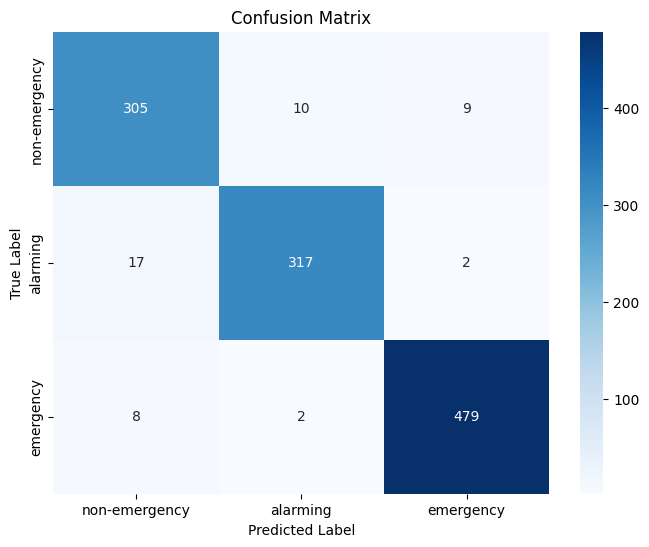

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rfc, X_train, y_train, cv=cv, scoring='f1_macro')
print(f"Cross-validation F1 Macro scores: {cv_scores}")
print(f"Mean CV F1 Macro score: {np.mean(cv_scores)}")

y_pred = best_rfc.predict(X_test)
# y_pred = best_rfc.predict_proba(X_test)
# threshold = 0.3
# y_pred = (y_pred[:, 1] >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['non-emergency', 'alarming', 'emergency'],
            yticklabels=['non-emergency', 'alarming', 'emergency'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=["non-emergency", "alarming", "emergency"])

print(f"Accuracy: {accuracy*100:.2f}%")
print("Classification Report:", class_report)

Accuracy: 95.82%
Classification Report:                precision    recall  f1-score   support

non-emergency       0.92      0.94      0.93       324
     alarming       0.96      0.94      0.95       336
    emergency       0.98      0.98      0.98       489

     accuracy                           0.96      1149
    macro avg       0.96      0.95      0.95      1149
 weighted avg       0.96      0.96      0.96      1149



In [14]:
sample_file = "glassbreak_2.wav"

wav, sr = load_audio_files(ALARMING_PATH, sample_file)
augmented_audio = augment_audio(wav, sr)
for augmented in augmented_audio:
    features = extract_features(augmented, sr)

prediction = best_rfc.predict(features.reshape(1, -1))
# prediction = rfc.predict_proba(features.reshape(1, -1))
# threshold = 0.3
# prediction = (prediction[:, 1] >= threshold).astype(int)

print(f"Prediction for {sample_file}: {'emergency' if prediction[0] == 2 else 'alarming' if prediction[0] == 1 else 'non-emergency'}")

Prediction for glassbreak_2.wav: alarming


In [15]:
joblib.dump(best_rfc, 'mfcc_rf_model.joblib')

['mfcc_rf_model.joblib']